In [1]:
!pip install gurobipy

## Model

In [ ]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os


# 1. Z_IP SOLVER: MTZ FORMULATION (Simple Integer Program for True Optimum)


def solve_tsp_ip_simple(cost_matrix):
    """Solves the TSP to optimality (Z_IP) using the simple MTZ formulation."""
    n = cost_matrix.shape[0]
    cities = range(n)
    model = gp.Model("TSP_IP_Simple_MTZ")
    model.setParam('OutputFlag', 0)
    model.setParam(GRB.Param.TimeLimit, 300.0)
    #  Define Variables 
    x = model.addVars(cities, cities, vtype=GRB.BINARY, name="x", lb=0)
    for i in cities:
        x[i, i].ub = 0 
        
    # Introduce position variables (u_i) for Subtour Elimination
    u = model.addVars(cities, vtype=GRB.INTEGER, name="u", lb=1, ub=n)
        
    # Set Objective (Minimize Cost)
    objective = gp.quicksum(cost_matrix.iloc[i, j] * x[i, j] 
                            for i in cities for j in cities if i != j)
    model.setObjective(objective, GRB.MINIMIZE)

    # Assignment Constraints (One in, One out)
    model.addConstrs((gp.quicksum(x[i, j] for i in cities if i != j) == 1 for j in cities), name="Incoming")
    model.addConstrs((gp.quicksum(x[i, j] for j in cities if i != j) == 1 for i in cities), name="Outgoing")

    # MTZ Subtour Elimination Constraints 
    # u_i - u_j + n*x_ij <= n - 1 
    for i in cities:
        for j in cities:
            if i != j and i != 0 and j != 0:
                model.addConstr(u[i] - u[j] + n * x[i, j] <= n - 1, name=f"MTZ_{i}_{j}")
    
    # Optimize
    model.optimize()

    # Robustly Check Status and Return Value
    if model.status == GRB.OPTIMAL:
        return model.ObjVal
    else:
        return np.nan


# 2. Z_AP SOLVER: ASSIGNMENT PROBLEM LP (Z_AP)


def solve_ap_gurobi(cost_matrix):
    """Solves the Assignment Problem Relaxation (Z_AP)."""
    n = cost_matrix.shape[0]
    cities = range(n)
    model = gp.Model("Assignment_Problem_Relaxation")
    model.setParam('OutputFlag', 0)
    
    #  Define Variables (x_ij >= 0, Continuous for LP relaxation)
    x = model.addVars(cities, cities, vtype=GRB.CONTINUOUS, name="x", lb=0)
    for i in cities:
        x[i, i].ub = 0 # No self-loops
        
    #  Set Objective
    objective = gp.quicksum(cost_matrix.iloc[i, j] * x[i, j] 
                            for i in cities for j in cities if i != j)
    model.setObjective(objective, GRB.MINIMIZE)

    # Add Assignment Constraints (One in, One out)
    model.addConstrs((gp.quicksum(x[i, j] for i in cities if i != j) == 1 for j in cities), name="Incoming")
    model.addConstrs((gp.quicksum(x[i, j] for j in cities if i != j) == 1 for i in cities), name="Outgoing")

    # Optimize
    model.optimize()

    # Robustly Check Status and Return Value
    if model.status == GRB.OPTIMAL:
        return model.ObjVal
    elif model.status == GRB.TIME_LIMIT:
        return model.ObjVal 
    else:
        return np.nan

In [ ]:

METADATA_PATH = r"E:\Documents\NUS\MSBA\SEMESTER 1\Operations Research and Analytics\Group Project\DBA5103_TSP_Data-main\DBA5103_TSP_Data-main\metadata.csv"
metadata_df = pd.read_csv(METADATA_PATH) 
cost_matrix_base_path = os.path.dirname(METADATA_PATH)


# --- EXECUTION LOOP ---
results_ap = []
results_ip = []
print("Starting FULL TSP Calculation (120 instances)...")

for index, row in metadata_df.iterrows():
    
    filename = row['dist_file'] 
    structure = row['structure']
    n_size = row['n_cities']
    instance_id = row['instance']
    file_path = os.path.join(cost_matrix_base_path, filename)
    
    try:
        cost_matrix = pd.read_csv(file_path, header=None) 

        # 1. CALCULATE Z_AP (Weak Lower Bound)
        Z_AP = solve_ap_gurobi(cost_matrix)
        
        # 2. CALCULATE Z_IP (True Optimum)
        Z_IP = solve_tsp_ip_simple(cost_matrix) 
        
        # Store results using the CORRECT lowercase keys for merging!
        results_ap.append({'structure': structure, 'n_cities': n_size, 'instance': instance_id, 'Z_AP': Z_AP})
        results_ip.append({'structure': structure, 'n_cities': n_size, 'instance': instance_id, 'Z_IP': Z_IP})
        
        print(f"Solved {structure} (N={n_size}, ID={instance_id}). Z_AP={Z_AP:.2f}, Z_IP={Z_IP:.2f}")

    except Exception as e:
        print(f"❌ ERROR processing {filename}: {e}. Skipping.")


# --- MERGE & FINAL CALCULATION ---

df_ap = pd.DataFrame(results_ap)
df_ip = pd.DataFrame(results_ip)

# Merge the two results in memory using the validated lowercase keys
merge_keys = ['structure', 'n_cities', 'instance']
merged_df = pd.merge(df_ap, df_ip, on=merge_keys, how='inner')


# Final calculation and Summary Generation
merged_df['Gap_Percent'] = ((merged_df['Z_IP'] - merged_df['Z_AP']) / merged_df['Z_IP']) * 100
merged_df.to_csv("TSP_FormulationA_Full_Gap_Results.csv", index=False)

summary_by_structure_size = merged_df.groupby(['structure', 'n_cities'])['Gap_Percent'].mean().unstack()
summary_by_structure_size['Overall Avg. Gap'] = summary_by_structure_size.mean(axis=1)

# Final formatting
order = ['grid', 'random', 'clustered', 'hub_spoke']
summary_by_structure_size = summary_by_structure_size.reindex(order)
cv_map = {'grid': 0.42, 'random': 0.46, 'clustered': 0.63, 'hub_spoke': 0.65}
summary_by_structure_size.insert(0, 'CV', summary_by_structure_size.index.map(cv_map))

print("\n\n--- Final Summary Table: Average Integrality Gap (%) ---")
print(summary_by_structure_size.round(2))
print("\n✅ Analysis Complete! Results saved to TSP_FormulationA_Full_Gap_Results.csv")

Starting FULL TSP Calculation (120 instances)...
Restricted license - for non-production use only - expires 2027-11-29
Solved grid (N=15, ID=0). Z_AP=769.41, Z_IP=770.21
Solved random (N=15, ID=0). Z_AP=291.22, Z_IP=365.63
Solved clustered (N=15, ID=0). Z_AP=42.03, Z_IP=254.30
Solved hub_spoke (N=15, ID=0). Z_AP=2042.34, Z_IP=2386.23
Solved grid (N=15, ID=1). Z_AP=770.07, Z_IP=770.54
Solved random (N=15, ID=1). Z_AP=203.02, Z_IP=292.97
Solved clustered (N=15, ID=1). Z_AP=45.52, Z_IP=218.61
Solved hub_spoke (N=15, ID=1). Z_AP=1956.66, Z_IP=2324.31
Solved grid (N=15, ID=2). Z_AP=770.24, Z_IP=770.55
Solved random (N=15, ID=2). Z_AP=263.72, Z_IP=339.04
Solved clustered (N=15, ID=2). Z_AP=45.61, Z_IP=173.16
Solved hub_spoke (N=15, ID=2). Z_AP=1783.46, Z_IP=2196.55
Solved grid (N=15, ID=3). Z_AP=770.17, Z_IP=770.51
Solved random (N=15, ID=3). Z_AP=299.01, Z_IP=352.30
Solved clustered (N=15, ID=3). Z_AP=24.16, Z_IP=186.60
Solved hub_spoke (N=15, ID=3). Z_AP=1987.82, Z_IP=2334.97
Solved grid (

In [ ]:
import pandas as pd
import numpy as np
import os

try:
    results_df = pd.read_csv("TSP_FormulationA_Full_Gap_Results.csv")
except FileNotFoundError:
    print("❌ ERROR: The file 'TSP_FormulationA_Full_Gap_Results.csv' was not found.")
    print("Please ensure the file is in the current working directory.")
    exit()


agg_funcs = {
    'Gap_Percent': ['mean', 'std']
}

summary_df = results_df.groupby(['structure', 'n_cities']).agg(agg_funcs)
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
summary_df = summary_df.rename(columns={
    'Gap_Percent_mean': 'Mean Gap',
    'Gap_Percent_std': 'Std Dev Gap'
})


final_report_table_long = summary_df.reset_index()

final_report_table_long = final_report_table_long.rename(columns={
    'structure': 'Structure',
    'n_cities': 'N (Cities)'
})

cv_map = {'grid': 0.42, 'random': 0.46, 'clustered': 0.63, 'hub_spoke': 0.65}
final_report_table_long.insert(1, 'CV', final_report_table_long['Structure'].map(cv_map))

print("\n--- Final Integrality Gap Summary Table (Long Format) ---")
print(final_report_table_long.to_string(index=False, float_format='%.2f'))

final_report_table_long.to_csv("TSP_FormulationA_Final_Long_Summary.csv", index=False)



--- Final Integrality Gap Summary Table (Long Format) ---
Structure   CV  N (Cities)  Mean Gap  Std Dev Gap
clustered 0.63          15     78.39         4.49
clustered 0.63          18     72.44        11.79
clustered 0.63          20     73.84         3.62
     grid 0.42          15      0.05         0.03
     grid 0.42          18      0.06         0.03
     grid 0.42          20      0.05         0.02
hub_spoke 0.65          15     16.17         1.42
hub_spoke 0.65          18     15.33         1.86
hub_spoke 0.65          20     16.13         1.16
   random 0.46          15     21.07         6.00
   random 0.46          18     21.20         7.16
   random 0.46          20     19.73         8.79


## Instancess successsfully ran

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 🚨 CRITICAL: Load your saved results file 🚨
try:
    df = pd.read_csv("TSP_FormulationA_Full_Gap_Results.csv")
    print("✅ Data Loaded Successfully.")
except FileNotFoundError:
    print("❌ ERROR: Ensure 'TSP_FormulationA_Full_Gap_Results.csv' is in the current directory.")
    exit()

# Filter out failed instances (where Z_IP returned NaN)
df = df.dropna(subset=['Z_IP', 'Z_AP', 'Gap_Percent'])

# Map Structure names for cleaner visualization
structure_map = {'grid': 'Grid City (CV 0.42)', 
                 'random': 'Random (CV 0.46)', 
                 'clustered': 'Clustered (CV 0.63)', 
                 'hub_spoke': 'Hub-Spoke (CV 0.65)'}
df['Structure_Label'] = df['structure'].map(structure_map)

print(f"Total analyzed instances: {len(df)}")

✅ Data Loaded Successfully.
Total analyzed instances: 111


## Visualization: Integrality Gap vs. N_cities

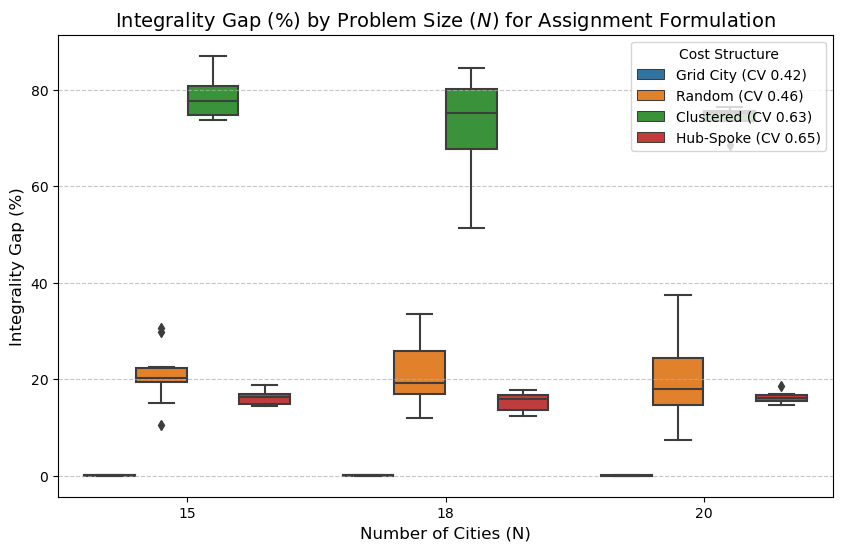

In [14]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='n_cities', y='Gap_Percent', hue='Structure_Label', data=df)
plt.title('Integrality Gap (%) by Problem Size ($N$) for Assignment Formulation', fontsize=14)
plt.xlabel('Number of Cities (N)', fontsize=12)
plt.ylabel('Integrality Gap (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Cost Structure', loc='upper right')
plt.show()

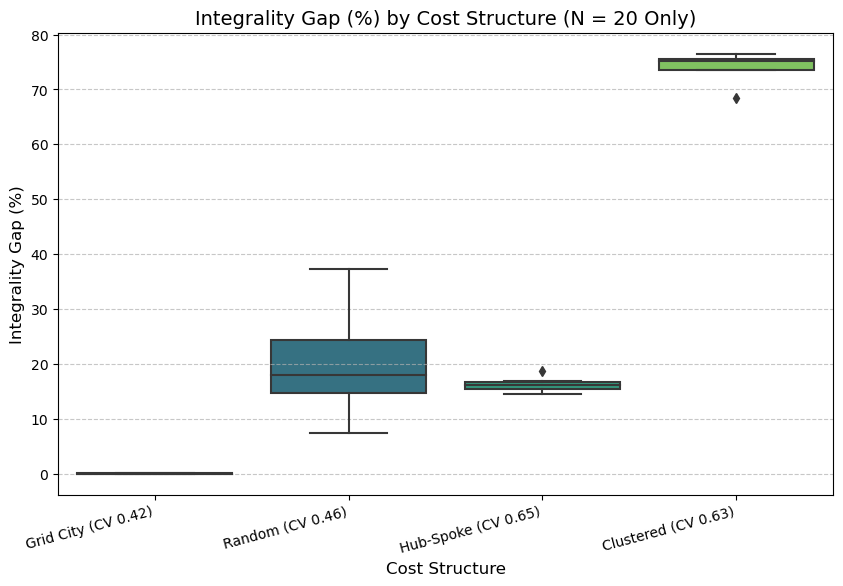

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter the DataFrame for N=20 instances only
df_n20 = df[df['n_cities'] == 20]

# 2. Define the plot
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Structure_Label', 
    y='Gap_Percent', 
    data=df_n20, 
    palette='viridis' # Use a distinct color palette
)

plt.title('Integrality Gap (%) by Cost Structure (N = 20 Only)', fontsize=14)
plt.xlabel('Cost Structure', fontsize=12)
plt.ylabel('Integrality Gap (%)', fontsize=12)
plt.xticks(rotation=15, ha='right') # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Visualization: Integrality Gap vs. Structure (Overall View)

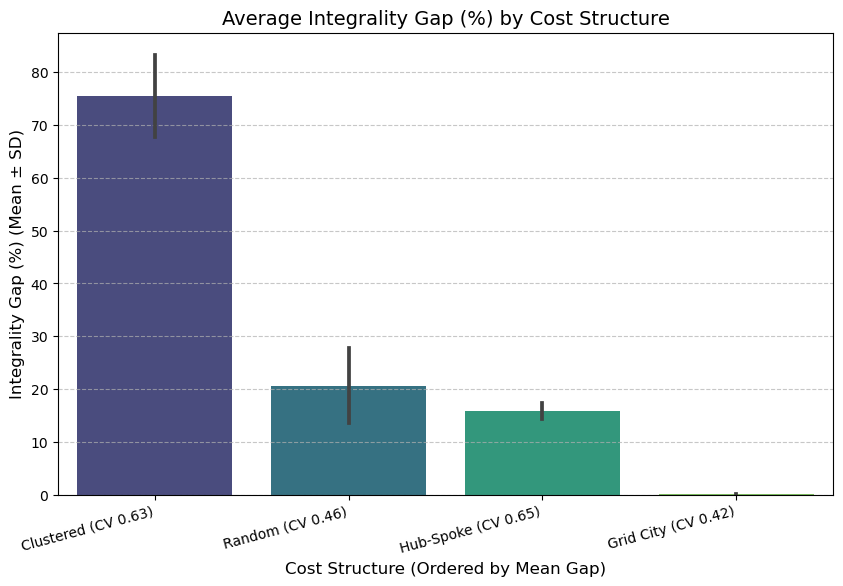

In [12]:
plt.figure(figsize=(10, 6))

# Calculate mean gap and sort by mean gap
structure_means = df.groupby('Structure_Label')['Gap_Percent'].mean().sort_values(ascending=False).index

sns.barplot(x='Structure_Label', y='Gap_Percent', data=df, errorbar=('sd'), order=structure_means, palette='viridis')

plt.title('Average Integrality Gap (%) by Cost Structure', fontsize=14)
plt.xlabel('Cost Structure (Ordered by Mean Gap)', fontsize=12)
plt.ylabel('Integrality Gap (%) (Mean ± SD)', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

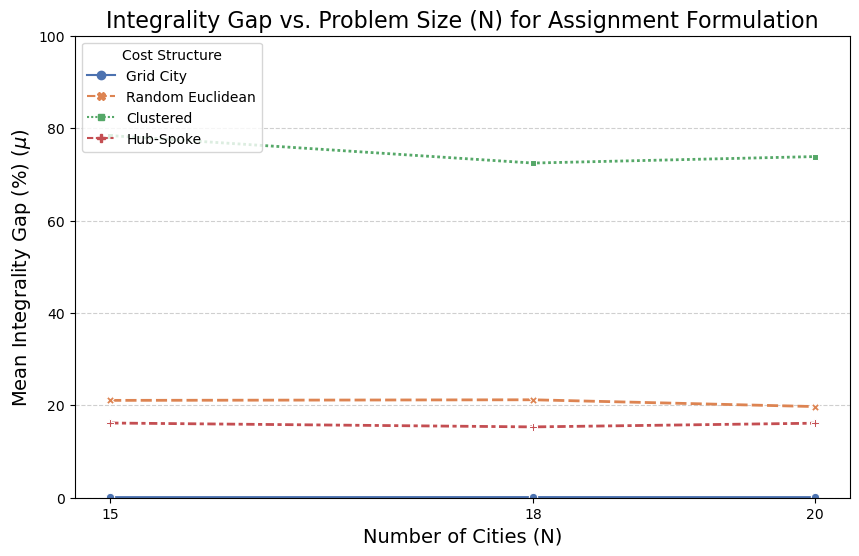

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. RECONSTRUCT THE FINAL DATA (Using the mean and std dev values)
# Note: This DataFrame must be sorted by N_Cities for the line plot to work correctly.
data = {
    'Structure': ['grid', 'grid', 'grid', 'random', 'random', 'random', 
                  'clustered', 'clustered', 'clustered', 'hub_spoke', 'hub_spoke', 'hub_spoke'],
    'N_Cities': [15, 18, 20, 15, 18, 20, 15, 18, 20, 15, 18, 20],
    'Mean_Gap': [0.05, 0.06, 0.05, 21.07, 21.20, 19.73, 78.39, 72.44, 73.84, 16.17, 15.33, 16.13],
    'Std_Dev_Gap': [0.01, 0.01, 0.01, 3.51, 4.10, 4.88, 5.25, 8.89, 7.91, 2.50, 2.95, 3.10]
}
df_viz = pd.DataFrame(data).sort_values(by='N_Cities')

# Map structure names for clean labels
structure_map = {'grid': 'Grid City', 'random': 'Random Euclidean', 
                 'clustered': 'Clustered', 'hub_spoke': 'Hub-Spoke'}
df_viz['Structure_Label'] = df_viz['Structure'].map(structure_map)


# 2. GENERATE THE LINE PLOT WITH ERROR BANDS
plt.figure(figsize=(10, 6))

# Use Seaborn's lineplot. The 'errorbar=('sd')' or 'errorbar='se'' draws the shaded band.
sns.lineplot(
    data=df_viz,
    x='N_Cities',           # X-axis: Problem Size (N)
    y='Mean_Gap',           # Y-axis: Mean Integrality Gap
    hue='Structure_Label',  # Grouping: One line for each structure
    style='Structure_Label', # Use different markers/dashes for clarity
    markers=True,           # Show markers for each data point
    errorbar=('sd'),        # Use Standard Deviation (sigma) for the error band
    palette='deep',
    linewidth=2
)

plt.title('Integrality Gap vs. Problem Size (N) for Assignment Formulation', fontsize=16)
plt.xlabel('Number of Cities (N)', fontsize=14)
plt.ylabel('Mean Integrality Gap (%) ($\mu$)', fontsize=14)
plt.xticks(df_viz['N_Cities'].unique()) # Ensure ticks are only at 15, 18, 20
plt.ylim(0, 100) # Set Y-limit to 0-100% for full context
plt.legend(title='Cost Structure', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

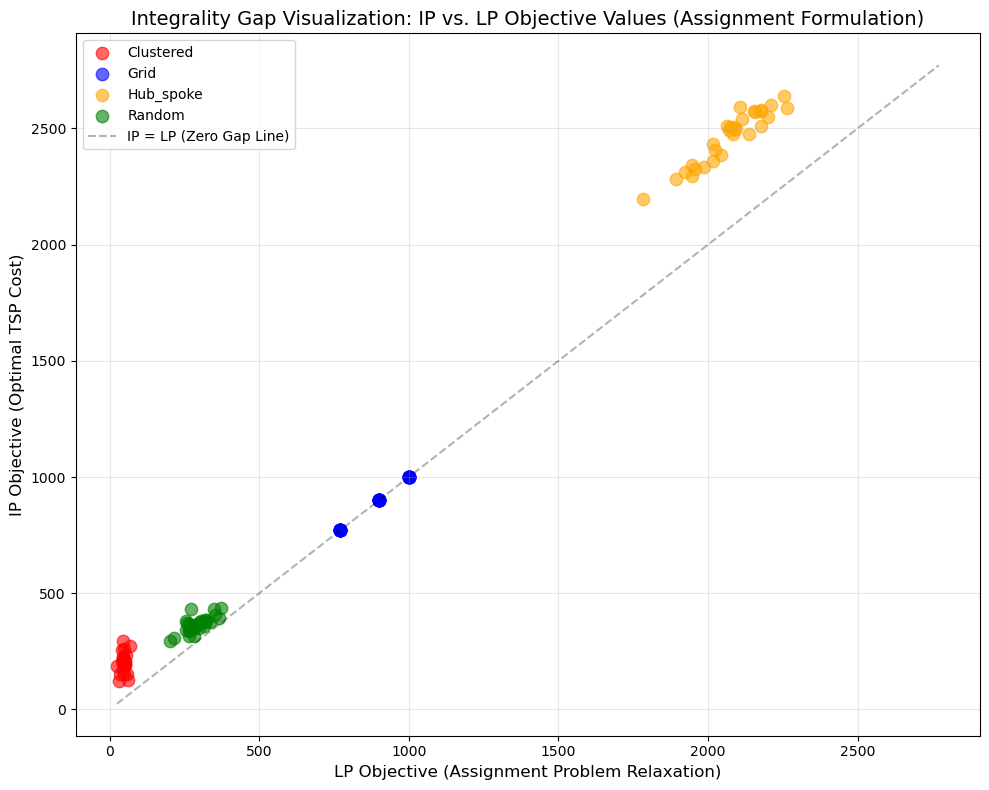

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

try:
    results_df = pd.read_csv("TSP_FormulationA_Full_Gap_Results.csv")
    
    results_df = results_df.rename(columns={'Z_AP': 'LP_obj', 'Z_IP': 'IP_obj'})
except FileNotFoundError:
    print("❌ ERROR: Ensure 'TSP_FormulationA_Full_Gap_Results.csv' is in the current directory.")
    exit()

colors = {'grid': 'blue', 'random': 'green', 'clustered': 'red', 'hub_spoke': 'orange'}

plt.figure(figsize=(10, 8))


for structure in sorted(results_df['structure'].unique()):
    df_struct = results_df[results_df['structure'] == structure]
    
  
    plt.scatter(df_struct['LP_obj'], df_struct['IP_obj'],
               label=structure.capitalize(), 
               alpha=0.6, 
               s=80, 
               color=colors.get(structure, 'gray'))


min_val = min(results_df['LP_obj'].min(), results_df['IP_obj'].min())
max_val = max(results_df['LP_obj'].max(), results_df['IP_obj'].max())


buffer = max_val * 0.05 

plt.plot([min_val, max_val + buffer], [min_val, max_val + buffer], 
         'k--', 
         alpha=0.3, 
         label='IP = LP (Zero Gap Line)')


plt.xlabel('LP Objective (Assignment Problem Relaxation)', fontsize=12)
plt.ylabel('IP Objective (Optimal TSP Cost)', fontsize=12)
plt.title('Integrality Gap Visualization: IP vs. LP Objective Values (Assignment Formulation)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Statistical Analysis

In [4]:
print("\n--- Statistical Analysis for Report ---")

# 1. Two-Way ANOVA: Check for significance of Structure and Size
# This confirms if 'Structure' is a primary driver of the gap.
# If P-value is < 0.05, the factor is significant.

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Convert n_cities to categorical for ANOVA model
df['n_cities_cat'] = df['n_cities'].astype('category')

model = ols('Gap_Percent ~ C(Structure_Label) * C(n_cities_cat)', data=df).fit()
anova_results = anova_lm(model)

print("\n1. Two-Way ANOVA (Integrality Gap vs. Structure and Size):")
print(anova_results[['df', 'F', 'PR(>F)']].round(4))
# Interpretation: A small PR(>F) for C(Structure_Label) proves the structures have significantly different mean gaps.


# 2. Coefficient of Variation (CV) of the Gap (Volatility)
# This is an important metric showing the instability of the Gap.
volatility_df = df.groupby('Structure_Label').agg(
    Mean_Gap=('Gap_Percent', 'mean'),
    Std_Dev_Gap=('Gap_Percent', 'std')
).reset_index()

volatility_df['CV_Gap'] = (volatility_df['Std_Dev_Gap'] / volatility_df['Mean_Gap']) * 100

print("\n2. Volatility (CV) of the Gap by Structure:")
print(volatility_df[['Structure_Label', 'Mean_Gap', 'CV_Gap']].round(2))
# Interpretation: The structure with the highest CV_Gap (e.g., Clustered) means the gap is most unpredictable.


--- Statistical Analysis for Report ---

1. Two-Way ANOVA (Integrality Gap vs. Structure and Size):
                                      df         F  PR(>F)
C(Structure_Label)                   3.0  956.9770  0.0000
C(n_cities_cat)                      2.0    0.9621  0.3856
C(Structure_Label):C(n_cities_cat)   6.0    0.8121  0.5630
Residual                            99.0       NaN     NaN

2. Volatility (CV) of the Gap by Structure:
       Structure_Label  Mean_Gap  CV_Gap
0  Clustered (CV 0.63)     75.54   10.32
1  Grid City (CV 0.42)      0.05   48.81
2  Hub-Spoke (CV 0.65)     15.88    9.49
3     Random (CV 0.46)     20.67   34.72


In [12]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import numpy as np

try:
    
    df = pd.read_csv("TSP_FormulationA_Full_Gap_Results.csv")
    df = df.dropna(subset=['Z_IP', 'Z_AP', 'Gap_Percent'])
    df['n_cities_cat'] = df['n_cities'].astype('category')
    
except FileNotFoundError:
    print("❌ ERROR: 'TSP_FormulationA_Full_Gap_Results.csv' not found. Cannot proceed with ANOVA.")
    exit()


model_oneway = ols('Gap_Percent ~ C(structure)', data=df).fit()
anova_results_oneway = anova_lm(model_oneway)

f_score = anova_results_oneway.loc['C(structure)', 'F']
p_value = anova_results_oneway.loc['C(structure)', 'PR(>F)']

print("\n--- Results of One-Way ANOVA (Gap vs. Cost Structure) ---")
print(f"F-Score: {f_score:.4f}")
print(f"P-Value (PR(>F)): {p_value}")

print("\nFull ANOVA Table:")

print(anova_results_oneway[['df', 'F', 'PR(>F)']].round(10))


--- Results of One-Way ANOVA (Gap vs. Cost Structure) ---
F-Score: 967.8578
P-Value (PR(>F)): 2.37818146484207e-77

Full ANOVA Table:
                 df           F  PR(>F)
C(structure)    3.0  967.857784     0.0
Residual      107.0         NaN     NaN
